In [1]:
library(sp)
library(rgdal)
library(raster)
library(rgeos)
library(maptools)

rgdal: version: 1.2-12, (SVN revision 681)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.4/Resources/library/rgdal/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.4/Resources/library/rgdal/proj
 Linking to sp version: 1.2-5 
rgeos version: 0.3-25, (SVN revision 555)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 r0 
 Linking to sp version: 1.2-5 
 Polygon checking: TRUE 

Checking rgeos availability: TRUE


## Load in the data sets that we will be using:

In [4]:
# After signing in to the J drive, load in a raster file:
# This describes, at a 5kmX5km scale (or close to thereabouts, 
# using latitude and longitude), the population in every "pixel"

# worldpop is a RasterLayer object, which is a single-layer raster 
# of the map of the world with pop values at each pixel
worldpop <- raster("/Volumes/snfs/WORK/11_geospatial/01_covariates/00_MBG_STANDARD/worldpop/total/5y/worldpop_total_5y_2015_00_00.tif")


## Read in shape files
(working with these can be slow in R)

In [6]:
# A shape file stores data that partition landscapes into subparts, 
# such as country borders
# GAUL compiles and disseminates information on administrative 
# units for countries worldwide
# admin0 refers to the highest level of administrative unit
# admin1 and higher are more fine-grained levels of administrative unit
world <- readShapePoly("/Volumes/snfs/WORK/11_geospatial/06_original shapefiles/GAUL_admin/admin0/g2015_2014_0/g2015_2014_0.shp")


Warning message:
“use rgdal::readOGR or sf::st_read”

In [7]:
# Another shape file, this time using IHME's definitions for 
# administrative regions
# This will have different names/codes for different countries
GBD <- readShapePoly("/Volumes/snfs/DATA/SHAPE_FILES/GBD_geographies/master/GBD_2016/master/shapefiles/GBD2016_analysis_final.shp")

Warning message:
“use rgdal::readOGR or sf::st_read”

In [8]:
# Pull out the part of the shape file data
# that describes the borders of Uganda
UGA <- world[world$ADM0_NAME=="Uganda",]

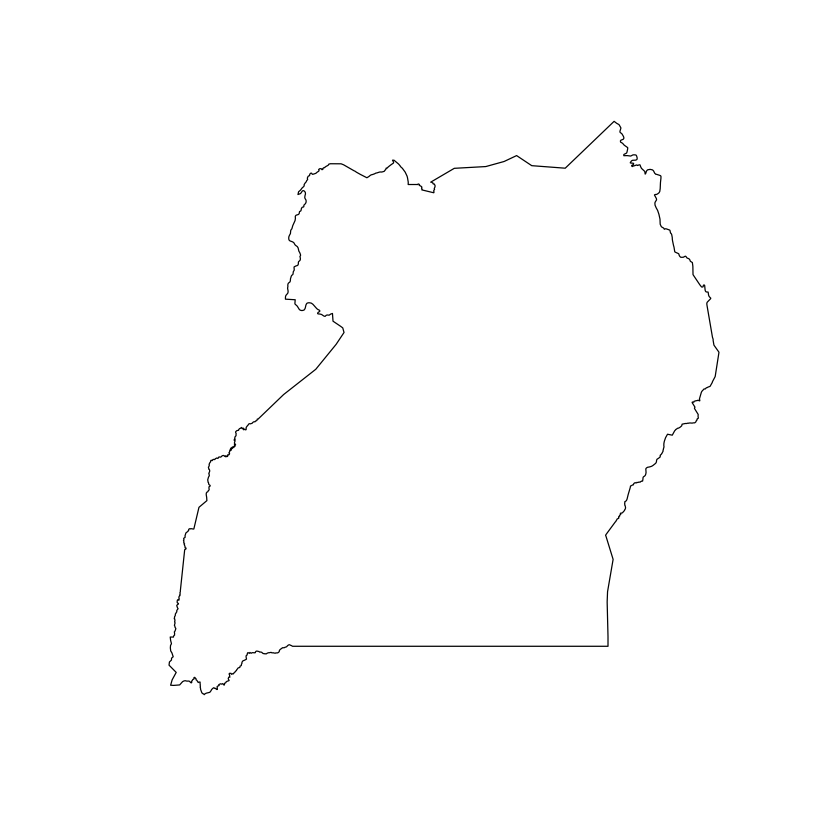

In [9]:
# We can even plot Uganda as well
plot(UGA)

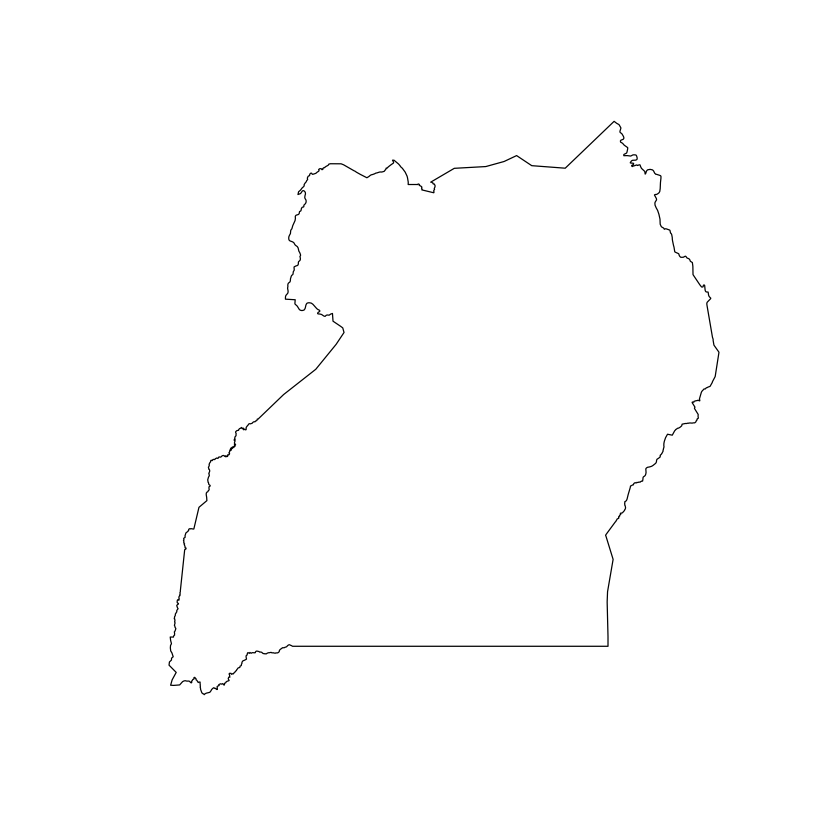

In [12]:
# Extract the population from the raster data using the GBD's shape file:
UGA.GBD <- GBD[GBD$loc_name=="Uganda",]
plot(UGA.GBD)

## Extract population from raster data

In [10]:
# Extract the population from the raster data
# This works by starting with a raster object, and using the shape file
# to define the boundaries of that object
# fun is the function used to aggregate data
# na.rm refers to removing the parts of the map with "NA" values given, 
# ie water
UGA.pop <- extract(worldpop, UGA, fun = sum, na.rm = TRUE)
print(UGA.pop)

         [,1]
[1,] 39069969


# Exercise

## Locate all of the sub-regions of Uganda

In [14]:
# Need to open a different shape file, that defines lower-level
# administrative regions
world.admin1 <- readShapePoly("/Volumes/snfs/WORK/11_geospatial/06_original shapefiles/GAUL_admin/admin1/g2015_2014_1/g2015_2014_1.shp")

Warning message:
“use rgdal::readOGR or sf::st_read”

In [16]:
# Find the set of administrative regions included within Uganda
# ADM0_NAME are the country names
# ADM1_NAME are the names of smaller administrative regions 
# inside countries
UGA.admin1 <- world.admin1[world.admin1$ADM0_NAME=="Uganda",]

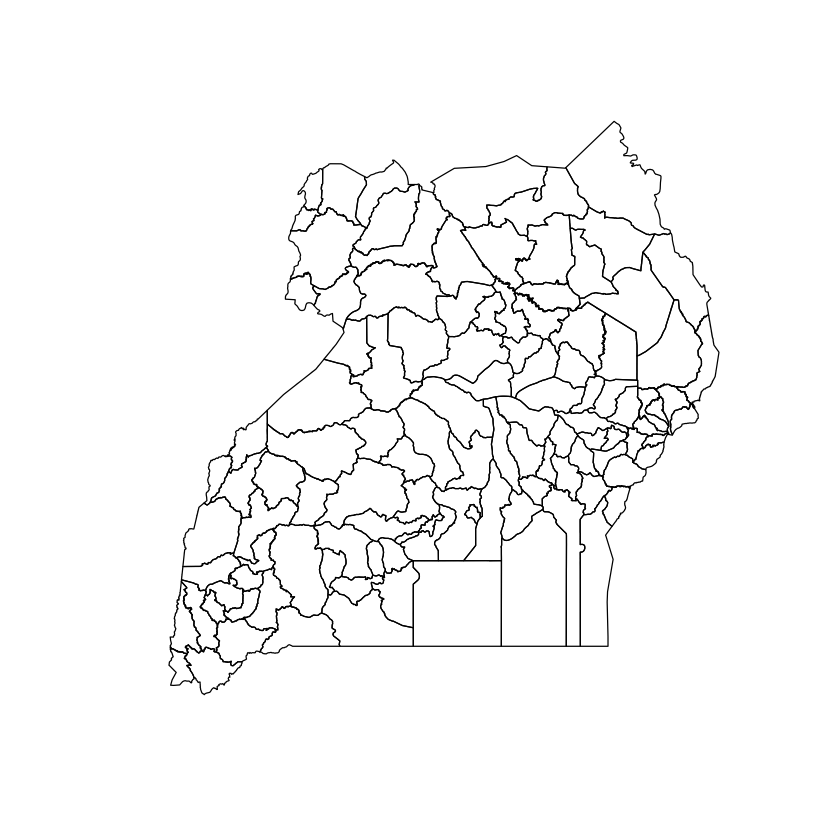

In [17]:
plot(UGA.admin1)

In [18]:
UGA.admin1.names  <- UGA.admin1$ADM1_NAME[order(UGA.admin1$ADM1_NAME)]
print(UGA.admin1in1.names)

  [1] Abim          Adjumani      Agago         Alebtong      Amolatar     
  [6] Amudat        Amuria        Amuru         Apac          Arua         
 [11] Budaka        Bududa        Bugiri        Buhweju       Buikwe       
 [16] Bukedea       Bukomansimbi  Bukwo         Bulambuli     Buliisa      
 [21] Bundibugyo    Bushenyi      Busia         Butaleja      Butambala    
 [26] Buvuma        Buyende       Dokolo        Gomba         Gulu         
 [31] Hoima         Ibanda        Iganga        Isingiro      Jinja        
 [36] Kaabong       Kabale        Kabarole      Kaberamaido   Kalangala    
 [41] Kaliro        Kalungu       Kampala       Kamuli        Kamwenge     
 [46] Kanungu       Kapchorwa     Kasese        Katakwi       Kayunga      
 [51] Kibaale       Kiboga        Kibuku        Kiruhura      Kiryandongo  
 [56] Kisoro        Kitgum        Koboko        Kole          Kotido       
 [61] Kumi          Kween         Kyankwanzi    Kyegegwa      Kyenjojo     
 [66] Lamwo 

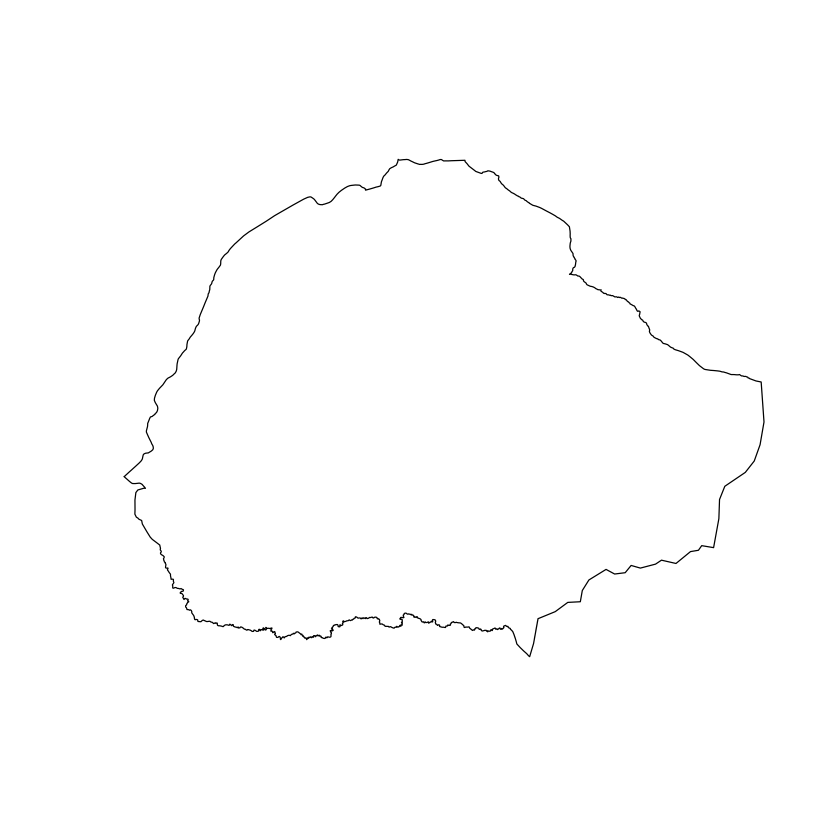

In [19]:
# Pull out Tororo, and plot:
TOR <- UGA.admin1[UGA.admin1$ADM1_NAME=="Tororo",]
plot(TOR)

In [20]:
# What is the population of Tororo?
TOR.pop <- extract(worldpop, TOR, fun = sum, na.rm = TRUE)
print(TOR.pop)

         [,1]
[1,] 639189.8


# Show Raster within the borders of Uganda

In [21]:
# Use the crop() function to zoom in on the extent defined by Uganda
UGA.pop <- crop(worldpop, extent(UGA))

In [26]:
# Use the mask() function to stencil out the region inside Uganda
UGA.pop.mask <- mask(UGA.pop, UGA)

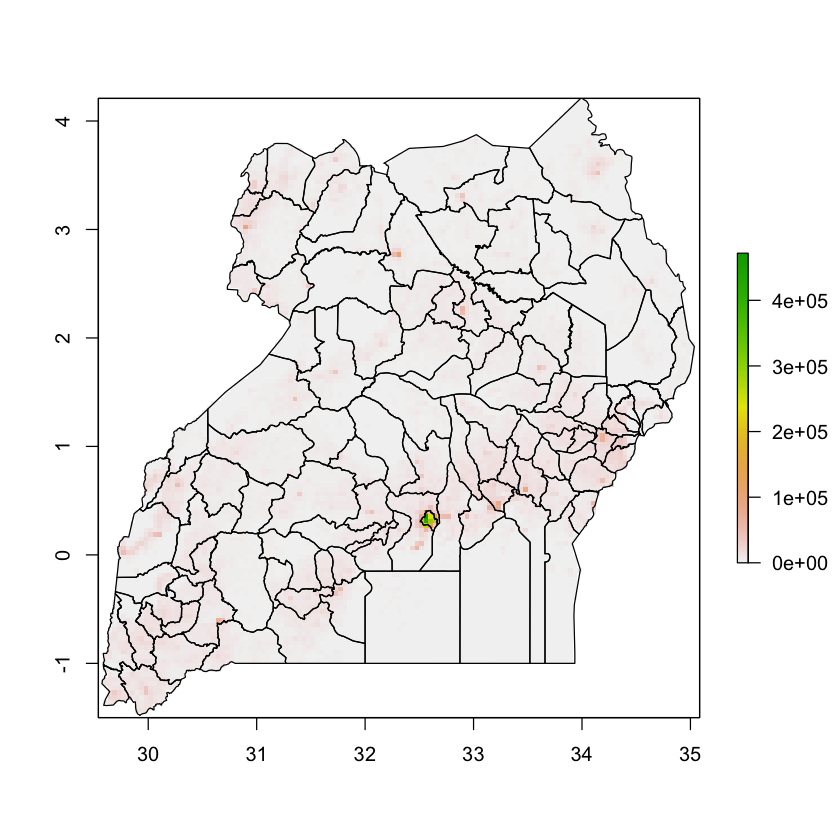

In [25]:
# Make a plot of population raster
# Superpose the admin regions over the image
plot(UGA.pop.mask)
plot(UGA.admin1, add = TRUE)

In [28]:
# Now let's plot Tororo in the same way:
TOR.pop <-crop(worldpop, extent(TOR))
TOR.pop.mask <- mask(TOR.pop, TOR)

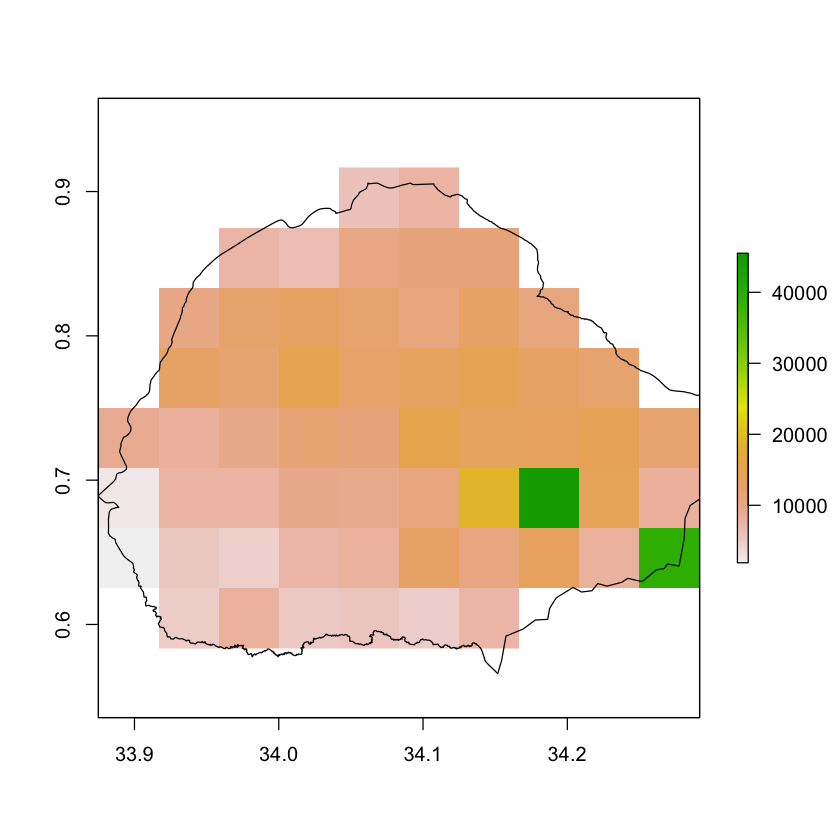

In [32]:
plot(TOR.pop.mask)
plot(TOR, add = TRUE)

## Adjacency
Let's identify all of the regions adjacent to Tororo

In [33]:
library(Matrix)
library(spdep)

In [42]:
# Generate a "neighbors" list
# Q/Queen tells the algorithm to include diagonally-touching neighbor pixels
# (as opposed to Rook)
UGA.nb = poly2nb(UGA.admin1, queen = TRUE, row.names = UGA.admin1$ADM1_NAME)

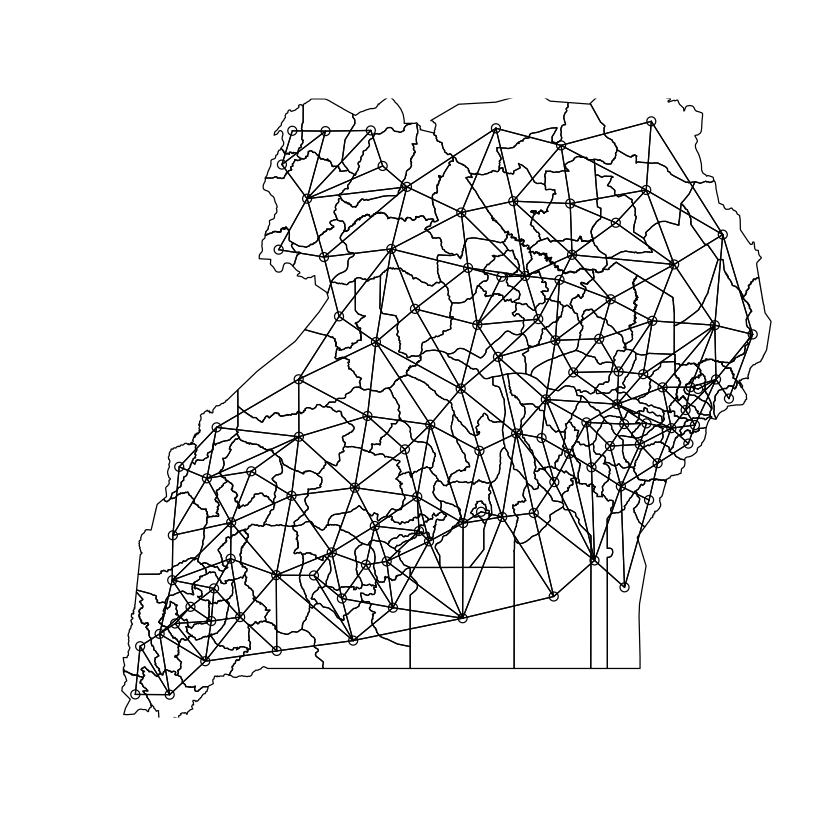

In [43]:
# Plot to show how the neighbor list encodes regional adjacencies
plot(UGA.nb, coordinates(UGA.admin1))
plot(UGA.admin1, add = TRUE)

In [44]:
# poly2nb returns a nb object, which we want to turn into a Matrix
mat <- nb2mat(UGA.nb)>0

In [46]:
# These are the neighbors of Tororo
TOR.neighbors <- rownames(mat)[mat['Tororo',]]
print(TOR.neighbors)

[1] "Busia"    "Butaleja" "Mbale"    "Manafwa"  "Bugiri"  


In [47]:
# Extract the combined region that includes all of the neighbors
# listed in TOR.neighbors:
y <- Reduce("|", lapply(X = TOR.neighbors, FUN = function(x){UGA.admin1$ADM1_NAME==x}))
TOR.neighbors.plot <- UGA.admin1[y,]

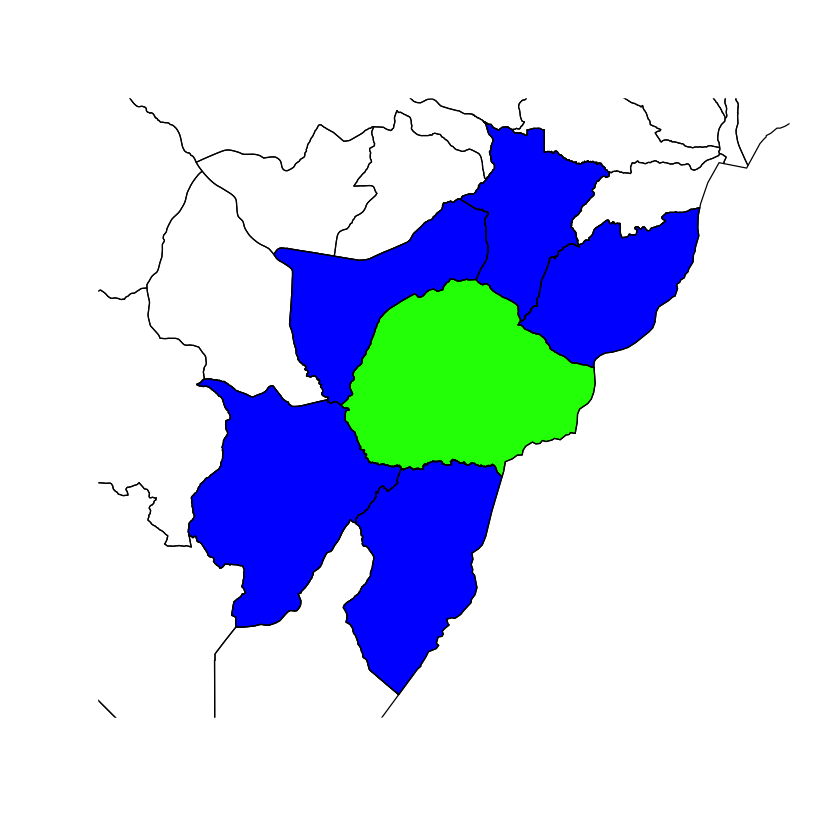

In [48]:
plot(TOR.neighbors.plot, col = "Blue")
plot(TOR, col = "Green", add = TRUE)
plot(UGA.admin1, add = TRUE)